In [1]:
# import statements
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image, ImageOps
import numpy as np
import os

# gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

let's define the dataset class to take in images and vectors, and the NN itself

In [2]:
import math
class MixedDataset(Dataset):
    def __init__(self, image_dir, bio_data, labels, ids, transform=None, train=True, train_stats = None):
        self.image_dir = image_dir
        self.bio_data = bio_data
        self.labels = labels
        self.transform = transform
        self.ids = ids
        self.train = train
        self.train_stats = train_stats

        if train:
            self.labels = torch.log10(self.labels)
            self.mean = torch.mean(self.labels, dim=0)
            self.std = torch.std(self.labels, dim=0)

            mask = torch.abs(self.labels - self.mean) <= 3 * self.std
            self.labels = self.labels[mask.all(dim=1)]
            self.bio_data = self.bio_data[mask.all(dim=1)]
            self.ids = self.ids[mask.all(dim=1)]

            self.min_target = torch.min(self.labels, dim=0)[0]
            self.max_target = torch.max(self.labels, dim=0)[0]
            self.labels = (self.labels - self.min_target) / (self.max_target - self.min_target)

            self.min_bio = torch.min(self.bio_data, dim=0)[0]
            self.max_bio = torch.max(self.bio_data, dim=0)[0]
            self.bio_data = (self.bio_data - self.min_bio) / (self.max_bio - self.min_bio)

        else:
            self.bio_data = (self.bio_data - self.train_stats[0]) / (self.train_stats[1] - self.train_stats[0])

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image = Image.open(os.path.join(self.image_dir, f'{self.ids[idx].numpy()}.jpeg')).convert('RGB')

        if self.transform:
            image = self.transform(image)
        
        bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)

        # we don't have labels for the test set
        label = torch.tensor(self.labels[idx], dtype=torch.float32) if len(self.labels) != 0 else torch.tensor(0)
        return image, bio_data, label

class MixedDataModel(nn.Module):
    def __init__(self):
        super(MixedDataModel, self).__init__()

        self.image_branch = models.resnet50(pretrained=True)
        for param in self.image_branch.parameters():
          param.requires_grad = False
        
        self.image_branch.fc.requires_grad = True

        # this is the layer that comes off right from the resnet model
        self.image_branch.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(self.image_branch.fc.in_features, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
        )

        # this is the numerical input layers
        self.bio_branch = nn.Sequential(
            nn.Linear(163, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )

        # this is the concatenation + regression layer
        self.regressor = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 6)
        )

    def forward(self, image, bio_data):
        image_out = self.image_branch(image)
        bio_out = self.bio_branch(bio_data)
        combined = torch.cat((image_out, bio_out), dim=1)
        return self.regressor(combined)

# random transofrmations/augmentations to build robustness
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation((0, 30)),
    transforms.ColorJitter(contrast=(0.85, 1.15), saturation=(0.85, 1.15), brightness=(0.85, 1.15)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.clamp(0, 1)),
])

# just normalize for testing and validation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

let's instantiate our model, the loss function and the optimizer

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
csv_path = 'submit\\data\\cs-480-2024-spring\\data\\train.csv'
df = pd.read_csv(csv_path)
train_df, val_df = train_test_split(df, test_size=0.2)

ids = train_df.iloc[:, 0].to_numpy()
features = train_df.iloc[:, 1:-6].to_numpy()
labels = train_df.iloc[:, -6:].to_numpy()

val_ids = val_df.iloc[:, 0].to_numpy()
val_features = val_df.iloc[:, 1:-6].to_numpy()
val_labels = val_df.iloc[:, -6:].to_numpy()

features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)
ids_tensor = torch.tensor(ids, dtype=torch.int64)

val_features_tensor = torch.tensor(val_features, dtype=torch.float32)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.float32)
val_ids_tensor = torch.tensor(val_ids, dtype=torch.int64)

mixed_dataset = MixedDataset('submit\\data\\cs-480-2024-spring\\data\\train_images', features_tensor, labels_tensor, ids_tensor, transform=transform)
train_loader = DataLoader(mixed_dataset, batch_size=32, shuffle=True)

val_dataset = MixedDataset('submit\\data\\cs-480-2024-spring\\data\\train_images', val_features_tensor, val_labels_tensor, val_ids_tensor, transform=test_transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

model = MixedDataModel()
model.to(device)

# define MSE loss and adamw optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)
print(device)

c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


let's train for 50 epochs with the current lr of 0.0001 and decay rate of 1e-3

In [4]:
num_epochs = 50
val_losses = []
train_losses = []
torch.cuda.empty_cache()
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        if (i % 100 == 99):
          print(i, end = ' ')
        images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        outputs = model(images, inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))
    print(' ')
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader):
            images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad()
            outputs = model(images, inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        print(val_loss / len(val_loader), end = ' ')
    
    torch.save(model.state_dict(), f'./models/modelV5_epoch_{epoch}.pth')

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

C:\Users\Alirz\AppData\Local\Temp\ipykernel_19340\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)
C:\Users\Alirz\AppData\Local\Temp\ipykernel_19340\2161391897.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32) if len(self.labels) != 0 else torch.tensor(0)


99 199 299 399 499 599 699 799 899  
2.09178637686046 Epoch [1/50], Loss: 0.0397
99 199 299 399 499 599 699 799 899  
1.1248792465399151 Epoch [2/50], Loss: 0.0295
99 199 299 399 499 599 699 799 899  
0.44005913567929134 Epoch [3/50], Loss: 0.0277
99 199 299 399 499 599 699 799 899  
0.31140336466704305 Epoch [4/50], Loss: 0.0270
99 199 299 399 499 599 699 799 899  
0.20208164554858496 Epoch [5/50], Loss: 0.0266
99 199 299 399 499 599 699 799 899  
0.13836954712023136 Epoch [6/50], Loss: 0.0262
99 199 299 399 499 599 699 799 899  
0.2417149781456843 Epoch [7/50], Loss: 0.0259
99 199 299 399 499 599 699 799 899  
0.12266816654306674 Epoch [8/50], Loss: 0.0257
99 199 299 399 499 599 699 799 899  
0.06501983036758446 Epoch [9/50], Loss: 0.0255
99 199 299 399 499 599 699 799 899  
0.05670361201229848 Epoch [10/50], Loss: 0.0253
99 199 299 399 499 599 699 799 899  
0.0343174802192189 Epoch [11/50], Loss: 0.0252
99 199 299 399 499 599 699 799 899  
0.03851066565193869 Epoch [12/50], Loss: 0.

let's save the losses and reload the last model saved

In [5]:
import json
with open(f'overfitV7.json', 'w') as f:
    json.dump({
        "train": train_losses,
        "val": val_losses
    }, f)

In [4]:
model = MixedDataModel()
model.load_state_dict(torch.load('./models/modelV5_epoch_49.pth'))
model.to(device)

MixedDataModel(
  (image_branch): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

let's create the test outputs to submit on kaggle

In [7]:
preds = []
test_csv_path = 'submit\\data\\cs-480-2024-spring\\data\\test.csv'
test_df = pd.read_csv(test_csv_path)

test_ids = test_df.iloc[:, 0]
test_features = test_df.iloc[:, 1:].to_numpy()

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_ids_tensor = torch.tensor(test_ids.to_numpy(), dtype=torch.int64)

test_dataset = MixedDataset('submit\\data\\cs-480-2024-spring\\data\\test_images', test_features_tensor, [], test_ids_tensor, transform=test_transform, train=False, train_stats=(mixed_dataset.min_bio, mixed_dataset.max_bio, mixed_dataset.min_target, mixed_dataset.max_target))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
torch.cuda.empty_cache()
for i, data in enumerate(test_dataloader, 0):
    inputs, images, labels = data[0].to(device), data[1].to(device), None
    optimizer.zero_grad()

    outputs = model(inputs, images)

    # this is to unnormalize
    outputs = (outputs * (mixed_dataset.max_target.to(device) - mixed_dataset.min_target.to(device))) + mixed_dataset.min_target.to(device)
    outputs = torch.pow(10, outputs)
    outputs = outputs.detach().cpu().numpy()
    preds.append(outputs)

C:\Users\Alirz\AppData\Local\Temp\ipykernel_19340\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)


In [8]:
import numpy as np
res = pd.DataFrame(np.concatenate(preds), columns = ["X4", "X11", "X18", "X26", "X50", "X3112"])
res = pd.concat([test_ids, res], axis=1)
res.to_csv('./19Attempt.csv', index=False)

Reduce Training Rate & Try again

In [6]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001, weight_decay=1e-2)

num_epochs = 50
val_losses = []
train_losses = []
torch.cuda.empty_cache()
for epoch in range(50, 50+num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        if (i % 100 == 99):
          print(i, end = ' ')
        images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        outputs = model(images, inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))
    print(' ')
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader):
            images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad()
            outputs = model(images, inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        print(val_loss / len(val_loader), end = ' ')
    
    if (epoch % 5 ==4):
        torch.save(model.state_dict(), f'./models/modelV5_epoch_{epoch}.pth')

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)
C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32) if len(self.labels) != 0 else torch.tensor(0)


99 199 299 399 499 599 699 799 899  
0.03222226300974365 Epoch [51/50], Loss: 0.0234
99 199 299 399 499 599 699 799 899  
0.03179707584020339 Epoch [52/50], Loss: 0.0234
99 199 299 399 499 599 699 799 899  
0.03360502202410688 Epoch [53/50], Loss: 0.0234
99 199 299 399 499 599 699 799 899  
0.03312361481701314 Epoch [54/50], Loss: 0.0234
99 199 299 399 499 599 699 799 899  
0.03590898579250463 Epoch [55/50], Loss: 0.0234
99 199 299 399 499 599 699 799 899  
0.03431298272299622 Epoch [56/50], Loss: 0.0234
99 199 299 399 499 599 699 799 899  
0.035321263264608285 Epoch [57/50], Loss: 0.0233
99 199 299 399 499 599 699 799 899  
0.03485799571763166 Epoch [58/50], Loss: 0.0233
99 199 299 399 499 599 699 799 899  
0.03397218679428583 Epoch [59/50], Loss: 0.0233
99 199 299 399 499 599 699 799 899  
0.033260680780357675 Epoch [60/50], Loss: 0.0233
99 199 299 399 499 599 699 799 899  
0.03314719291833731 Epoch [61/50], Loss: 0.0233
99 199 299 399 499 599 699 799 899  
0.032283000557528814 Epoch

In [7]:
model = MixedDataModel()
model.load_state_dict(torch.load('./models/modelV5_epoch_99.pth'))
model.to(device)

c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MixedDataModel(
  (image_branch): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [8]:
preds = []
test_csv_path = 'submit\\data\\cs-480-2024-spring\\data\\test.csv'
test_df = pd.read_csv(test_csv_path)

test_ids = test_df.iloc[:, 0]
test_features = test_df.iloc[:, 1:].to_numpy()

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_ids_tensor = torch.tensor(test_ids.to_numpy(), dtype=torch.int64)

test_dataset = MixedDataset('submit\\data\\cs-480-2024-spring\\data\\test_images', test_features_tensor, [], test_ids_tensor, transform=test_transform, train=False, train_stats=(mixed_dataset.min_bio, mixed_dataset.max_bio, mixed_dataset.min_target, mixed_dataset.max_target))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
torch.cuda.empty_cache()
for i, data in enumerate(test_dataloader, 0):
    inputs, images, labels = data[0].to(device), data[1].to(device), None
    optimizer.zero_grad()

    outputs = model(inputs, images)
    outputs = (outputs * (mixed_dataset.max_target.to(device) - mixed_dataset.min_target.to(device))) + mixed_dataset.min_target.to(device)
    outputs = torch.pow(10, outputs)
    outputs = outputs.detach().cpu().numpy()
    preds.append(outputs)

C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)


In [9]:
import numpy as np
res = pd.DataFrame(np.concatenate(preds), columns = ["X4", "X11", "X18", "X26", "X50", "X3112"])
res = pd.concat([test_ids, res], axis=1)
res.to_csv('./21Attempt.csv', index=False)

In [11]:
import json
with open(f'overfitV9.json', 'w') as f:
    json.dump({
        "train": train_losses,
        "val": val_losses
    }, f)

Try to train on larger training rate to get out of plateaued loss

In [12]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

num_epochs = 5
val_losses = []
train_losses = []
torch.cuda.empty_cache()
for epoch in range(100, 100+num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        if (i % 100 == 99):
          print(i, end = ' ')
        images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        outputs = model(images, inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))
    print(' ')
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader):
            images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad()
            outputs = model(images, inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        print(val_loss / len(val_loader), end = ' ')
    
    if (epoch % 5 ==4):
        torch.save(model.state_dict(), f'./models/modelV5_epoch_{epoch}.pth')

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)
C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32) if len(self.labels) != 0 else torch.tensor(0)


99 199 299 399 499 599 699 799 899  
0.030247019852703883 Epoch [101/5], Loss: 0.0258
99 199 299 399 499 599 699 799 899  
0.03412025857731881 Epoch [102/5], Loss: 0.0255
99 199 299 399 499 599 699 799 899  
0.03537846462959461 Epoch [103/5], Loss: 0.0253
99 199 299 399 499 599 699 799 899  
0.03397051571502618 Epoch [104/5], Loss: 0.0252
99 199 299 399 499 599 699 799 899  
0.06405298420895449 Epoch [105/5], Loss: 0.0251


didn't work, let's revert and keep training for 60 more epochs and with a smaller learning rate

In [13]:
model = MixedDataModel()
model.load_state_dict(torch.load('./models/modelV5_epoch_99.pth'))
model.to(device)

c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MixedDataModel(
  (image_branch): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [14]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.000001, weight_decay=1e-4)

num_epochs = 60
val_losses = []
train_losses = []
torch.cuda.empty_cache()
for epoch in range(100, 100+num_epochs):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        if (i % 100 == 99):
          print(i, end = ' ')
        images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
        optimizer.zero_grad()
        outputs = model(images, inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss/len(train_loader))
    print(' ')
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(val_loader):
            images, inputs, labels = data[0].to(device), data[1].to(device), data[2].to(device)
            optimizer.zero_grad()
            outputs = model(images, inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        
        val_losses.append(val_loss / len(val_loader))
        print(val_loss / len(val_loader), end = ' ')
    
    if (epoch % 5 ==4):
        torch.save(model.state_dict(), f'./models/modelV5_epoch_{epoch}.pth')

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)
C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32) if len(self.labels) != 0 else torch.tensor(0)


99 199 299 399 499 599 699 799 899  
0.0372272002612531 Epoch [101/60], Loss: 0.0230
99 199 299 399 499 599 699 799 899  
0.03606941060800301 Epoch [102/60], Loss: 0.0231
99 199 299 399 499 599 699 799 899  
0.036822258649386375 Epoch [103/60], Loss: 0.0230
99 199 299 399 499 599 699 799 899  
0.03775363416233767 Epoch [104/60], Loss: 0.0230
99 199 299 399 499 599 699 799 899  
0.03617276506204354 Epoch [105/60], Loss: 0.0230
99 199 299 399 499 599 699 799 899  
0.03851354372525505 Epoch [106/60], Loss: 0.0231
99 199 299 399 499 599 699 799 899  
0.0378332122828555 Epoch [107/60], Loss: 0.0231
99 199 299 399 499 599 699 799 899  
0.03804623510552804 Epoch [108/60], Loss: 0.0231
99 199 299 399 499 599 699 799 899  
0.0383590253801481 Epoch [109/60], Loss: 0.0231
99 199 299 399 499 599 699 799 899  
0.038160578268561285 Epoch [110/60], Loss: 0.0231
99 199 299 399 499 599 699 799 899  
0.03879603876276055 Epoch [111/60], Loss: 0.0230
99 199 299 399 499 599 699 799 899  
0.0387421925797274

In [19]:
model = MixedDataModel()
model.load_state_dict(torch.load('./models/modelV5_epoch_104.pth'))
model.to(device)

c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MixedDataModel(
  (image_branch): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [20]:
preds = []
test_csv_path = 'submit\\data\\cs-480-2024-spring\\data\\test.csv'
test_df = pd.read_csv(test_csv_path)

test_ids = test_df.iloc[:, 0]
test_features = test_df.iloc[:, 1:].to_numpy()

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_ids_tensor = torch.tensor(test_ids.to_numpy(), dtype=torch.int64)

test_dataset = MixedDataset('submit\\data\\cs-480-2024-spring\\data\\test_images', test_features_tensor, [], test_ids_tensor, transform=test_transform, train=False, train_stats=(mixed_dataset.min_bio, mixed_dataset.max_bio, mixed_dataset.min_target, mixed_dataset.max_target))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
torch.cuda.empty_cache()
for i, data in enumerate(test_dataloader, 0):
    inputs, images, labels = data[0].to(device), data[1].to(device), None

    optimizer.zero_grad()

    outputs = model(inputs, images)
    outputs = (outputs * (mixed_dataset.max_target.to(device) - mixed_dataset.min_target.to(device))) + mixed_dataset.min_target.to(device)
    outputs = torch.pow(10, outputs)
    outputs = outputs.detach().cpu().numpy()
    preds.append(outputs)

C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_data = torch.tensor(self.bio_data[idx], dtype=torch.float32)


In [21]:
import numpy as np
res = pd.DataFrame(np.concatenate(preds), columns = ["X4", "X11", "X18", "X26", "X50", "X3112"])
res = pd.concat([test_ids, res], axis=1)
res.to_csv('./24Attempt.csv', index=False)

In [18]:
import json
with open(f'overfitV10.json', 'w') as f:
    json.dump({
        "train": train_losses,
        "val": val_losses
    }, f)

let's look at some statistics for our data for the paper and run our best algorithm several times to get the average r-squared.

In [35]:
print(mixed_dataset.max_bio)
print(mixed_dataset.min_bio)
print(mixed_dataset.std)
print(mixed_dataset.mean)
print(mixed_dataset.max_target)
print(mixed_dataset.min_target)
print(sum([param.numel() for param in model.parameters()]))
print(len(mixed_dataset))
print(len(df.index))

tensor([3.0294e+01, 8.3925e+03, 2.4490e+03, 1.6958e+02, 1.8245e+03, 6.3641e+01,
        1.6400e+02, 1.9100e+02, 1.7800e+02, 1.8500e+02, 1.7000e+02, 1.8900e+02,
        7.9500e+02, 5.8500e+02, 6.2200e+02, 6.2500e+02, 6.1700e+02, 5.8400e+02,
        4.4900e+02, 5.1600e+02, 4.6200e+02, 4.5900e+02, 4.4800e+02, 4.7800e+02,
        6.0100e+02, 7.0800e+02, 6.4200e+02, 6.9500e+02, 6.0400e+02, 7.0300e+02,
        2.4650e+03, 1.4180e+03, 2.3230e+03, 2.1580e+03, 2.3200e+03, 1.5210e+03,
        1.0150e+03, 9.9000e+02, 9.3000e+02, 8.1200e+02, 9.9100e+02, 9.2000e+02,
        1.7300e+02, 9.1000e+01, 9.5000e+01, 9.1000e+01, 9.2000e+01, 9.1000e+01,
        9.5000e+01, 9.6300e+02, 9.6000e+02, 9.6900e+02, 9.6100e+02, 9.6200e+02,
        9.5400e+02, 7.7500e+02, 7.0800e+02, 7.4000e+02, 7.1900e+02, 7.7700e+02,
        7.1200e+02, 3.7980e+03, 4.2500e+03, 3.2980e+03, 4.0110e+03, 3.4600e+03,
        4.2650e+03, 1.3283e+04, 1.2900e+04, 1.2127e+04, 1.2981e+04, 7.2850e+03,
        7.9990e+03, 7.8210e+03, 7.2770e+

In [29]:
model = MixedDataModel()
model.load_state_dict(torch.load('./models/modelV5_epoch_99.pth'))
model.to(device)

preds = []
test_csv_path = 'submit\\data\\cs-480-2024-spring\\data\\test.csv'
test_df = pd.read_csv(test_csv_path)

test_ids = test_df.iloc[:, 0]
test_features = test_df.iloc[:, 1:].to_numpy()

test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_ids_tensor = torch.tensor(test_ids.to_numpy(), dtype=torch.int64)

test_dataset = MixedDataset('submit\\data\\cs-480-2024-spring\\data\\test_images', test_features_tensor, [], test_ids_tensor, transform=test_transform, train=False, train_stats=(mixed_dataset.min_bio, mixed_dataset.max_bio, mixed_dataset.min_target, mixed_dataset.max_target))
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
torch.cuda.empty_cache()
for i, data in enumerate(test_dataloader, 0):
    inputs, images, labels = data[0].to(device), data[1].to(device), None

    optimizer.zero_grad()

    outputs = model(inputs, images)
    outputs = (outputs * (mixed_dataset.max_target.to(device) - mixed_dataset.min_target.to(device))) + mixed_dataset.min_target.to(device)
    outputs = torch.pow(10, outputs)
    outputs = outputs.detach().cpu().numpy()
    preds.append(outputs)

res = pd.DataFrame(np.concatenate(preds), columns = ["X4", "X11", "X18", "X26", "X50", "X3112"])
res = pd.concat([test_ids, res], axis=1)
res.to_csv('./BestAttempt_4.csv', index=False)

c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alirz\Documents\2024 - UW\S2024\CS480\Final\project\project\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\2161391897.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bio_dat

let's plot the traits

C:\Users\Alirz\AppData\Local\Temp\ipykernel_15076\1972149549.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])


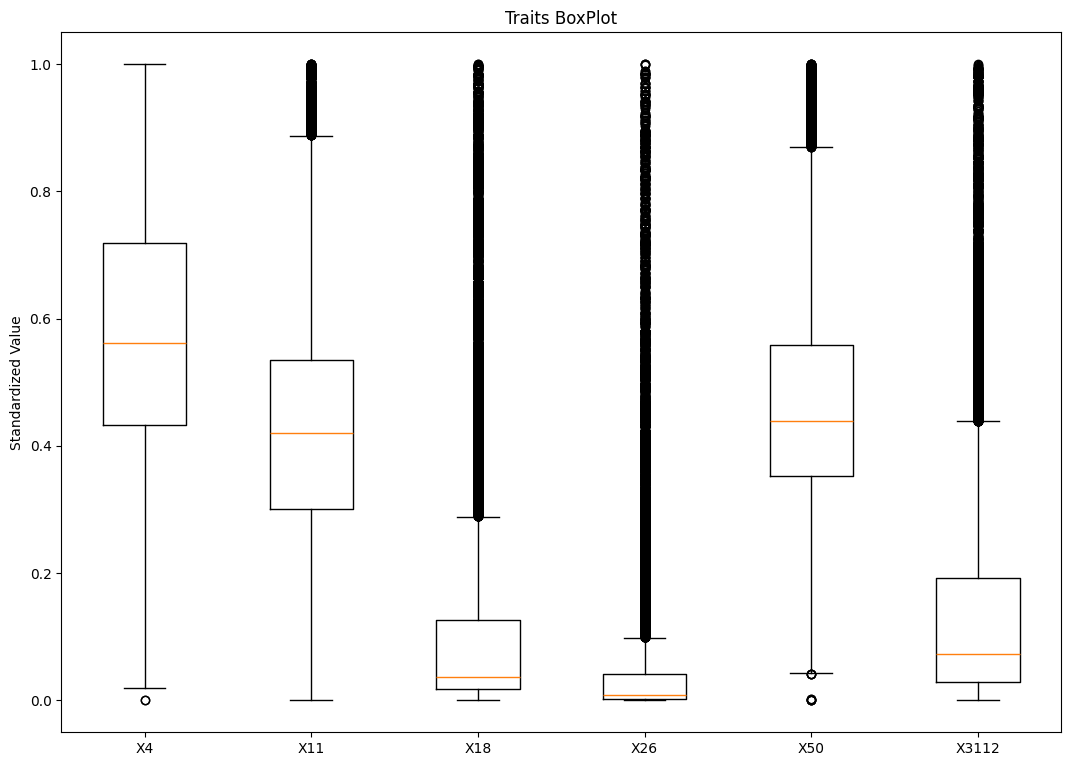

In [33]:
import matplotlib.pyplot as plt

box_data = []
for index in range(6):
    box_data.append(mixed_dataset.labels[:, index].numpy())

fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(['X4', 'X11', 'X18', 'X26', 'X50', 'X3112'])
ax.set_label('Traits')
ax.set_ylabel('Standardized Value')
bp = ax.boxplot(box_data)

plt.title(f"Traits BoxPlot")
plt.show()